In [1]:
from IPython.display import Image
from oct2py import octave as oct
from os.path import join
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_matlab_data(directory, filename):
    """
    Imports the matlab scripts generated during execution of
        C codes, and returns an array with the data neccesary
        for analysis of performance
    """
    print("before cd")
    oct.eval(f"cd {directory};")
    print(f"before running {filename}")
    oct.eval(f"{filename};")
    print("before saving")
    oct.eval(f"save -v7 {filename}.mat;")
    print("before loading")
    data = sio.loadmat(f"{join(directory, filename)}.mat")

    return data['data']

# Loop Ordering
Matrices are conceptually 2 dimensional arrays, but computer memory works
conceptually as a one dimensional block of bytes. Hence there is a need to
stablish some relationship or **mapping** between the way we humans visualize a
matrix and the way computers handle the information.

In the early days of scientific programming, the *Fortran* language was
prefered to carry on the computations. Fortran deciden to store matrices each
column at a time, which is known as **Column Major Order**, in this course this
is also the way matrices are stored in memory, if we were to store each row at
a time, it would be calles **Row Major Order**, the python module for
scientific computation, *Numpy*, stores its arrays following the latter
convention.

The mapping between a matrix `A` in mathematical notation and the same matrix
`A` stored in memory is
$
A = \begin{bmatrix}
\alpha_{0, 0} & \alpha_{0, 1} & \dots & \alpha_{0, n-1} \\
\alpha_{1, 0} & \alpha_{1, 1} & \dots & \alpha_{1, n-1} \\
\vdots & \vdots & \dots & \vdots \\
\alpha_{m-1, 0} & \alpha_{m-1, 1} & \dots & \alpha_{m-1, n-1} \\
\end{bmatrix}
= \begin{bmatrix}
\alpha_{0, 0} \\
\alpha_{0, 1} \\
\vdots \\
\alpha_{0, n-1} \\
--- \\
\alpha_{1, 0} \\
\alpha_{1, 1} \\
\vdots \\
\alpha_{1, n-1} \\
--- \\
\vdots \\
\vdots \\
--- \\
\alpha_{m-1, 0} \\
\alpha_{m-1, 1} \\
\vdots \\
\alpha_{m-1, n-1}
\end{bmatrix}
$

The matrix on the left is the mathematical representation of `A`, whereas the
*vector* on the left is the representation of the same matrix stored in
computational memory. We see how the first column is stored contiguously, and
is followed by the second column, and so on, until we store the whole array. As
a more friendly example

$
A = \begin{bmatrix}
1 & -2 & 2 \\
-1 & 1 & 3 \\
-2 & 2 & -1
\end{bmatrix}
= \begin{bmatrix}
1 \\ -1 \\ -2 \\ --- \\ -2 \\ 1 \\ 2 \\ --- \\ 2 \\ 3 \\ -1
\end{bmatrix}
$

Because a matrix is stored as a one dimensional array in memory, we can acces
different elements by indexing into the array, or by carrying on some *pointer
arithmetic*. This means that the elements in matrix `A` are accesible via a one
dimensional offset (index). In *C*, the value of the matrix `A` as a variable,
corresponds in reality to the address of the first element of the matrix, so
the first element of the matrix is `A`, or `A[0]` as well, since we are giving
it an offset of zero, then:
```python
| Matrix              | Array element | Array indexing     |
|---------------------|---------------|--------------------|
|$\alpha_{0, 0}$      |   A[0]        |  A[m * 0 + 0]      |
|$\alpha_{1, 0}$      |   A[1]        |  A[m * 0 + 1]      |
|$\alpha_{2, 0}$      |   A[2]        |  A[m * 0 + 2]      |
|...                  |   ...         |  ...               |
|$\alpha_{m-1, 0}$    |   A[m-1]      |  A[m * 0 + m-1]    |
| -------             |   -------     |  -------           |
|$\alpha_{0, 1}$      |   A[m]        |  A[m * 1 + 0]      |
|$\alpha_{1, 1}$      |   A[m + 1]    |  A[m * 1 + 1]      |
|...                  |   ...         |  ...               |
|$\alpha_{m-1, 1}$    |   A[m + m-1]  |  A[m * 1 + m-1]    |
| -------             |   -------     |  -------           |
|$\alpha_{i, j}$      |   ...         |  A[m * j + i]      |
| -------             |   -------     |  -------           |
|$\alpha_{0, n-1}$    |   ...         |  A[m * n-1 + 0]    |
|$\alpha_{1, n-1}$    |   ...         |  A[m * n-1 + 1]    |
|...                  |   ...         |  ...               |
|$\alpha_{m-1, n-1}$  |   ...         |  A[m * n-1 + m-1]  |
```

Here we can see that a formula is aricing from this indexing mapping between
the two representations. We can see that a corresponding entry $\alpha_{i, j}$
is stored at the array element `A[m * j + i]`.

$
A = \begin{bmatrix}
0.0 & 0.1 & 0.2 & 0.3 \\
1.0 & \textbf{1.1} & \textbf{1.2} & \textbf{1.3} \\
2.0 & \textbf{2.1} & \textbf{2.2} & \textbf{2.3} \\
3.0 & 3.1 & 3.2 & 3.3 \\
4.0 & 4.1 & 4.2 & 4.3 \\
\end{bmatrix}
;
Z = \begin{bmatrix}
\textbf{1.1} & \textbf{1.2} & \textbf{1.3} \\
\textbf{2.1} & \textbf{2.2} & \textbf{2.3} \\
\end{bmatrix}
$

This is why, in the code homeworks there are always some defined macros that
map the elements of the array with its mathematical representation

```C
#define alpha(i, j) A[(j) * m + i] // maps alpha(i, j) to array A
#define beta(i, j) B[(j) * m + i] // maps beta(i, j) to array B
#define gamma(i, j) C[(j) * m + i] // maps gamma(i, j) to array C
```

Now, in most of the cases, we would want to work by *slicing and dicing*, which
means that we will work with submatrices of bigger matrices. With this in mind,
a new concept is needed, called **leading dimension** of the matrix, and refers
to the dimension of the column (since we are using column major order) of the
bigger matrix, let's say for example that we have a matrix `A` and a submatrix
`Z` such that:

$
A = \begin{bmatrix}
0.0 & 0.1 & 0.2 & 0.3 \\
1.0 & \textbf{1.1} & \textbf{1.2} & \textbf{1.3} \\
2.0 & \textbf{2.1} & \textbf{2.2} & \textbf{2.3} \\
3.0 & 3.1 & 3.2 & 3.3 \\
4.0 & 4.1 & 4.2 & 4.3 \\
\end{bmatrix}
;
Z = \begin{bmatrix}
\textbf{1.1} & \textbf{1.2} & \textbf{1.3} \\
\textbf{2.1} & \textbf{2.2} & \textbf{2.3} \\
\end{bmatrix}
$

Since `Z` is a submatrix of `A`, in other words, the elements of `Z` are stored
in memory as entries of the array `A`, we cannot get for example to element
`Z[1, 1]` by taking the previous formula

```python
Z[i, j] = Z[m_z * j + i]

Z[1, 1] = Z[2 * 1 + 1] = Z[3]
```

to understand why this is not valid, recall that the code variables `A` and `Z`
store the address of the first element of the matrix, then

```python
Z = Z[0] = A[6]
```

and then

```python
Z[3] = A[9] = 4.1
```

and we see that $Z[1, 1] != 4.1$ but instead $Z[1, 1] = 2.2$. Here lies the
importance of the **leading dimension**, in this particular example, instead of
$m_z$, we need to multiplie in terms of the **leading dimension** of `A`, which
is the size of the columns $ldA = 5$, this with the objective of getting the
contiguous element row-wise direction. Following the same example, to get to
element `Z[1, 1]`, the formula needs to be modified to

```python
Z[i, j] = Z[ldA * j + i] = Z[5 * 1 + 1] 
= Z[6]
```

remembering that `Z = Z[0] = A[6]`

```python
Z[6] = A[12] = 2.2
```

With this in mind, the *real* macros defined in the homework codes are

```C
#define alpha(i, j) A[(j) * ldA + i] // maps alpha(i, j) to array A
#define beta(i, j) B[(j) * ldB + i] // maps beta(i, j) to array B
#define gamma(i, j) C[(j) * ldC + i] // maps gamma(i, j) to array C
```

## Loop Ordering
We have established the convention for iterators variables, this is
* `i` traverses the rows of `C` and `A`. Dimension `m`
* `j` traverses the columns of `C` and `B`. Dimension `n`
* `p` traverses the columns of `A` and the rows of `B`. The _inter dimension_
`k`

We have stablished a first approach, written again below for simplicity
```C
for (int i = 0; i < m; i++)
    for (int j = 0; j < n; j++)
        for (int p = 0; p < k; p++)
            /* gamma(i, j) += alpha(i, p) * beta(p, j) */
            C[j * ldB + i] += A[p * ldA + i] * B[j * ldB + p]
```

The order in which the `for` loops are performed makes no difference as long as
the operation is performed exactly as above, and it is performed only once.
With this in mind, we have `6` possible loop orderings, and as we will soon
see, each one of them has different performance even though they give the same
result in the end.



### Homework 1.2.4.2
In directory `Assignments/Week1/C` make copies of `Assignments/Week1/C/Gemm_IJP.c` into files with names that reflect the different loop orderings `(Gemm_IPJ.c, etc.)`. Next, make the necessary changes to the loops in each file to reflect the ordering encoded in its name. Test the implementions by executing

```bash
cd Assignments/Week1/C/
make IPJ
make JIP
   ...
```

for each of the implementations and view the resulting performance by making the indicated changes to the Live Script in Assignments/Week1/C/data/Plot_All_Orderings.mlx (Alternatively, use the script in Assignments/Week1/C/data/Plot_All_Orderings_m.m). If you have implemented them all, you can test them all by executing
```bash
make All_Orderings
```

When completed, various data is in output file 'output_XYZ.m' `(for XYZ
in XYZ {IJP,IPJ,JIP,JPI,PIJ,PJI})` in the same directory where you found this 

before cd
before running output_IJP
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
before saving
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
before loading
before cd
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
before running output_IPJ
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
before saving
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
before loading
before cd
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
before running output_JIP
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
before s

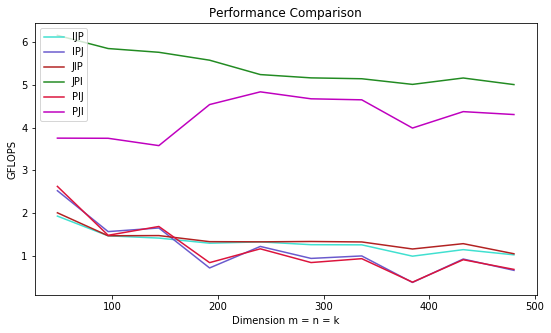

In [3]:
directory = join("..", "data")
files = ["output_IJP", "output_IPJ", "output_JIP", "output_JPI", "output_PIJ", "output_PJI"]
colors = ["turquoise", "slateblue", "firebrick", "forestgreen", "crimson", "m"]
figsize = [9, 5]


fig, ax = plt.subplots(1, figsize=figsize)
for file, color in zip(files, colors):
    data = get_matlab_data(directory, file)
    if np.any(data[:, 5] > 1e-10):
        raise Exception("Hmmm, better check if there is an accuracy problem")
    ax.plot(data[:, 0], data[:, 4], color=color, label=file[-3:])

ax.set_title("Performance Comparison")
ax.set_xlabel("Dimension m = n = k")
ax.set_ylabel("GFLOPS")
ax.legend(loc="upper left")

The two orderings with best performance have something in common, for both of them, the **most inner** `for loop` goes advances with the `i` iterator, which means that they both change the row of matrices `A` and `C` in every iteration, which implies that we are changing the row, while everything else stays in the same position, this is analogous as computing the dot product by **columns**. Since we are dealing with **column major order**, doing the computations by columns gives the best performance, since those elements are contiguous in memory.

Other thing that improves performance when computing by **columns**, is that the inner loop is the one that gets executed the most, it is convenient to have the *easiest* loop to compute as the most inner one, instead the another loop that costs most trouble to compute, **we want those to be executed the least possible**.

The following shows a visual representation of what the inner most loop computes
![PerformanceOfOrderingsWorksheet.png](./img/PerformanceOfOrderingsWorksheet.png)

Here it is more obvious what every inner most loop is doing for every ordering, as stated before, the two with the best performances perform the operations in the columns of `C` and `A`. The following picture shows, for the two best orderings, what does the mid loop computes, which helps us understand why one `JPI` is better than `PJI`, and this is, because the mid loop in `JPI` computes the rows of `A` and the columns of `B`, whereas `PJI` computes rows of both `C` and `B`. Since we've stablished that computing by rows is better than computing by rows, `JPI` wins because has one computation by columns, while `PJI` has *none*.
![PerformanceOfOrderingsWorksheet_2_best.png](./img/PerformanceOfOrderingsWorksheet_2_best.png)